# Investigating Student Behavior and Habits using Unsupervised Learning
# David Stanko, Aakash Krishna, Josh Wilkes

## Introduction

This work uses unsupervised learning to investigate patterns in student behavior and habits. We are using the [Student Habits and Academic Performance Dataset](https://www.kaggle.com/datasets/aryan208/student-habits-and-academic-performance-dataset?resource=download) from Kaggle datasets. It is a synthetic dataset containing features about students' lifestyle, backgrounds, habits, and academic performance. Some of the variables are the student's major, time spent studying, time spent on screens, mental health information, GPA, and exam scores. According to Kaggle, the goal of the dataset is explore how the last two variables are affected by the others. 

The data was generated using Python, with realistic statistical and algorithmic techniques to mimic real student behavior. Some things to note was that the exam score was derived from the GPA and some noise. The GPA was "computed based on study hours, sleep, stress, motivation, support, and tutoring" (Kaggle datasets page).

We will perform principal component analysis (PCA), matrix factorization, k-means clustering, and hierarchical clustering on this dataset. 

## Imports

In [94]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Data preprocessing

### Examine the dataset

In [77]:
X = pd.read_csv("enhanced_student_habits_performance_dataset.csv")
X.head()

,student_id,age,gender,major,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,...,screen_time,study_environment,access_to_tutoring,family_income_range,parental_support_level,motivation_level,exam_anxiety_score,learning_style,time_management_score,exam_score
0,100000,26,Male,Computer Science,7.645367,3.0,0.1,Yes,70.3,6.2,...,10.9,Co-Learning Group,Yes,High,9,7,8,Reading,3.0,100
1,100001,28,Male,Arts,5.700000,0.5,0.4,No,88.4,7.2,...,8.3,Co-Learning Group,Yes,Low,7,2,10,Reading,6.0,99
2,100002,17,Male,Arts,2.400000,4.2,0.7,No,82.1,9.2,...,8.0,Library,Yes,High,3,9,6,Kinesthetic,7.6,98
3,100003,27,Other,Psychology,3.400000,4.6,2.3,Yes,79.3,4.2,...,11.7,Co-Learning Group,Yes,Low,5,3,10,Reading,3.2,100
4,100004,25,Female,Business,4.700000,0.8,2.7,Yes,62.9,6.5,...,9.4,Quiet Room,Yes,Medium,9,1,10,Reading,7.1,98


In [78]:
X.shape

(80000, 31)

In [79]:
is_null = pd.isnull(X) # boolean mask of same size as X for whether each value is null
[sum(is_null[i]) for i in X.columns] # see how many missing values there are in each column

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

The raw data has 80,000 rows and 31 columns. There are no missing values.

In [80]:
dtypes = X.dtypes # examine data types
dtypes

student_id                         int64
age                                int64
gender                            object
major                             object
study_hours_per_day              float64
social_media_hours               float64
netflix_hours                    float64
part_time_job                     object
attendance_percentage            float64
sleep_hours                      float64
diet_quality                      object
exercise_frequency                 int64
parental_education_level          object
internet_quality                  object
mental_health_rating             float64
extracurricular_participation     object
previous_gpa                     float64
semester                           int64
stress_level                     float64
dropout_risk                      object
social_activity                    int64
screen_time                      float64
study_environment                 object
access_to_tutoring                object
family_income_ra

We have many categorical variables encoded as strings (e.g.: gender, major, extracurricular_participation), so we have to drop those. However, let's examine all the columns of type `float64`. Some of the `int64` columns might be categorical or unnecessary as well. However, we know any column of type `float64` is continuous numerical data.

In [81]:
categorical_cols = dtypes[dtypes != "float64"].index # get the index of the dtypes series, where the value in the series is not float64
categorical_cols

Index(['student_id', 'age', 'gender', 'major', 'part_time_job', 'diet_quality',
       'exercise_frequency', 'parental_education_level', 'internet_quality',
       'extracurricular_participation', 'semester', 'dropout_risk',
       'social_activity', 'study_environment', 'access_to_tutoring',
       'family_income_range', 'parental_support_level', 'motivation_level',
       'exam_anxiety_score', 'learning_style', 'exam_score'],
      dtype='object')

In [82]:
# Look at the unique values of each non-float column

for col in categorical_cols:
    print(f"\n{'-'*50} {col} {'-'*50}")
    print(f"Unique values: {X[col].unique()}")


-------------------------------------------------- student_id --------------------------------------------------
Unique values: [100000 100001 100002 ... 179997 179998 179999]

-------------------------------------------------- age --------------------------------------------------
Unique values: [26 28 17 27 25 19 16 24 21 22 23 20 18]

-------------------------------------------------- gender --------------------------------------------------
Unique values: ['Male' 'Other' 'Female']

-------------------------------------------------- major --------------------------------------------------
Unique values: ['Computer Science' 'Arts' 'Psychology' 'Business' 'Engineering' 'Biology']

-------------------------------------------------- part_time_job --------------------------------------------------
Unique values: ['Yes' 'No']

-------------------------------------------------- diet_quality --------------------------------------------------
Unique values: ['Poor' 'Good' 'Fair']

---------

Based on context and what the variables represent, we should drop `student_id`, `gender`, `major`, `part_time_job`, `diet_quality`, `parental_education_level`, `internet_quality`, `extracurricular_participation`, `semester`,
                      `dropout_risk`, `study_environment`, `access_to_tutoring`,
                      `family_income_range`, and `learning_style`. 
                      
We have some variables on a scale of 0-10 or 0-5, like `exercise_frequency` and `social_activity`. Even though those are discrete numerical variables, we think we should keep them because an exercise or social activity frequency of 1.5, for example, is meaningful and interpretable. Ratings like that do not have to be integers.

### Drop categorical variables and other irrelevant variables:

In [83]:
X = X.drop(columns = ["student_id", "gender", "major", "part_time_job",
                      "diet_quality", "exercise_frequency", "parental_education_level",
                      "internet_quality", "extracurricular_participation", "semester",
                      "dropout_risk", "study_environment", "access_to_tutoring",
                      "family_income_range", "learning_style"])

In [84]:
X.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,mental_health_rating,previous_gpa,stress_level,social_activity,screen_time,parental_support_level,motivation_level,exam_anxiety_score,time_management_score,exam_score
0,26,7.645367,3.0,0.1,70.3,6.2,6.0,4.00,5.8,0,10.9,9,7,8,3.0,100
1,28,5.700000,0.5,0.4,88.4,7.2,6.8,4.00,5.8,5,8.3,7,2,10,6.0,99
2,17,2.400000,4.2,0.7,82.1,9.2,5.7,3.79,8.0,5,8.0,3,9,6,7.6,98
3,27,3.400000,4.6,2.3,79.3,4.2,8.5,4.00,4.6,3,11.7,5,3,10,3.2,100
4,25,4.700000,0.8,2.7,62.9,6.5,9.2,4.00,5.7,2,9.4,9,1,10,7.1,98


### Scale the data

We will now scale the data to have zero mean and unit variance.

In [85]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns) # scaled dataset
X_scaled.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,mental_health_rating,previous_gpa,stress_level,social_activity,screen_time,parental_support_level,motivation_level,exam_anxiety_score,time_management_score,exam_score
0,1.066790,1.731919,0.344972,-1.641677,0.019161,-0.557064,-0.418464,0.858879,0.403204,-1.467026,0.441221,1.225264,0.527057,-0.283052,-0.959906,0.936783
1,1.600758,0.761237,-1.384614,-1.382158,1.063417,0.124429,-0.002138,0.858879,0.403204,1.466762,-0.493744,0.529203,-1.216462,0.830286,0.192381,0.850512
2,-1.336063,-0.885369,1.175173,-1.122639,0.699947,1.487414,-0.574587,0.405191,1.529583,1.466762,-0.601625,-0.862921,1.224465,-1.396390,0.806934,0.764242
3,1.333774,-0.386398,1.451907,0.261462,0.538405,-1.920049,0.882557,0.858879,-0.211185,0.293247,0.728903,-0.166859,-0.867758,0.830286,-0.883087,0.936783
4,0.799807,0.262265,-1.177064,0.607487,-0.407773,-0.352616,1.246843,0.858879,0.352005,-0.293511,-0.098182,1.225264,-1.565166,0.830286,0.614886,0.764242


In [86]:
X_scaled.shape

(80000, 16)

## PCA/SVD

Now, we will perform PCA on the scaled dataset and interpret the results.

In [87]:
pca = PCA()
pca_out = pca.fit_transform(X_scaled) # transformed values of X_scaled of shape (n_samples, n_components)

In [131]:
pca_out

array([[ 1.68466824,  0.31137425,  0.35022909, ...,  0.16049441,
        -0.07322955, -0.22490769],
       [-0.08834804,  0.01985968,  2.40369414, ..., -0.28230901,
         0.02784711,  0.19257449],
       [ 1.15880561, -1.71328905, -0.79318371, ..., -0.13639925,
        -0.25261161, -0.06510654],
       ...,
       [-1.73885956,  0.21563282,  1.1808412 , ..., -0.53479769,
        -0.6504475 , -0.19903149],
       [ 0.96934207, -0.97007396, -0.02672446, ...,  0.01953556,
        -0.33159663,  0.10384065],
       [ 1.89106496,  0.2863426 , -1.06526936, ...,  0.00975429,
        -0.05431772,  0.0660027 ]])

In [132]:
pca_out.shape

(80000, 16)

`pca.components_` are the "principal axes in feature space, representing the directions of maximum variance in the data" (sklearn documentation). `pca.components_` is a matrix where each row is a principal component and each column is a feature of the original data. It has shape `(n_components, n_features)`.

In [88]:
pca.components_.shape

(16, 16)

In [89]:
# Make a dataframe with the principal components as columns, where a row corresponds to each feature
principal_components = pd.DataFrame(pca.components_.T,
             index = X_scaled.columns,
             columns = [f"PC{i}" for i in range(1, 17)])

In [90]:
principal_components.sort_values(by = "PC1", ascending=False)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
previous_gpa,0.512138,-0.029378,0.390847,-0.077675,-0.005741,0.007384,-0.010487,0.006224,-0.007697,0.011472,-0.003311,-0.141472,0.224328,0.013032,0.712106,0.004001
exam_score,0.502559,-0.027323,0.401899,-0.082907,-0.005789,0.006822,-0.011135,0.006608,-0.009031,0.011278,-0.003531,-0.153771,0.248586,-0.026463,-0.701200,-0.000118
motivation_level,0.385541,-0.401876,-0.410575,0.051795,0.005350,-0.009555,0.006818,-0.003102,0.006055,-0.004841,0.000790,0.069280,-0.104266,0.708422,-0.028793,-0.000431
study_hours_per_day,0.291250,0.419916,0.021078,-0.157803,-0.149251,-0.052349,-0.090856,0.096746,0.123829,-0.148411,0.120860,0.462266,-0.365879,0.003210,-0.009511,-0.520810
screen_time,0.290528,0.582071,-0.264475,0.032507,0.006864,-0.005240,0.005899,-0.001320,0.009395,-0.007388,-0.005713,0.046943,-0.074266,0.000740,-0.007080,0.705498
social_media_hours,0.088989,0.313666,-0.327979,0.159588,-0.325999,0.099742,0.103626,-0.420776,-0.010447,0.321599,-0.218576,-0.332799,0.232007,-0.002097,0.004536,-0.375131
netflix_hours,0.070879,0.248817,-0.241602,0.147910,0.680815,-0.045485,0.039889,0.355192,-0.182834,-0.160668,0.050946,-0.277415,0.174317,0.000327,0.003977,-0.300479
sleep_hours,0.060247,-0.006692,0.175060,-0.099791,0.437252,0.054273,0.320797,-0.290907,-0.323803,0.370536,-0.412169,0.288133,-0.281002,0.001218,-0.005988,-0.000101
mental_health_rating,0.012954,0.002225,0.091847,0.710170,0.014466,-0.047324,0.003177,-0.067669,-0.006217,-0.055226,-0.009726,0.554315,0.411781,0.000539,0.000247,-0.000215
time_management_score,0.007481,0.003612,0.000321,0.009786,0.211557,0.673496,-0.225907,-0.063488,0.125153,0.411617,0.504871,0.079995,0.005409,0.000937,-0.001152,0.000289


The most important features in the dataset are `previous_gpa` and `exam_score`, because they have the highest magnitude loadings. However, recall that GPA was computed based on some other features, and that `exam_score` was computed from GPA. So, because `exam_score` and `previous_gpa` are calculated based on many other features, it makes sense that they are important, because they summarize a lot of the dataset.

In general, the most important features are (in order of importance):
- `previous_gpa`
- `exam_score`
- `motivation_level`
- `exam_anxiety_score`
- `study_hours_per_day`
- `screen_time`

`exam_anxiety_score` has a negative loading, and the other features mentioned above all have positive loadings. So, `exam_anxiety_score` is inversely correlated with the other features above. That means:
- Students who have a high `previous_gpa` have a low `exam_anxiety_score`. That makes sense because, if a student already has a high GPA, performing badly on future exams will not affect their GPA much. So, they won't be as anxious about exams.
- Students with a high `exam_score` have a low `exam_anxiety_score`. That makes sense because, if these students already perform well on exams, they're less anxious about future exams.
- Students with a high `exam_anxiety_score` have a low `motivation_level`. So, if students are anxious about exams, they are less motivated to do well in school. This was a surprising result to us, because we would expect that exam anxiety motivates students to perform better.
- Students who studied for more hours per day had a lower `exam_anxiety_score`, which makes sense
- Surprisingly, students with a high `screen_time` had a *low* `exam_anxiety_score`. We would expect the opposite to be true because screen time can negatively affect academic performance. However, more screen time helped students have less exam anxiety. Perhaps that's because screen time is a way to relax. 

Some features that are *not* important are `time_management_score`, `attendance_percentage`, `age`, `social_activity`, and `parental_support_level`. 

In [91]:
pve = pca.explained_variance_ratio_ # proportion of variance explained by each principal component
pve

array([0.16173982, 0.1222292 , 0.08939663, 0.0687587 , 0.06323569,
       0.06290213, 0.06264529, 0.06262927, 0.06240772, 0.0620661 ,
       0.06202574, 0.05719965, 0.05204963, 0.00519115, 0.00415874,
       0.00136455])

In [111]:
pve_cumulative = np.cumsum(pve) # Cumulative PVE
pve_cumulative

array([0.16173982, 0.28396902, 0.37336564, 0.44212434, 0.50536004,
       0.56826217, 0.63090746, 0.69353673, 0.75594445, 0.81801055,
       0.88003629, 0.93723594, 0.98928557, 0.99447672, 0.99863545,
       1.        ])

In [ ]:
# Make a scree plot
indices = np.arange(1, 17) # indices for the components from 1 to n_components

fig, axs = plt.subplots(nrows=1, ncols=2)

# Set axis label font size to 12
axs[0].tick_params(axis="both", labelsize=12)
axs[1].tick_params(axis="both", labelsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.set_size_inches(15, 7)
fig.suptitle("Scree Plot", fontsize=24)

# PVE plot
axs[0].plot(indices, pve, marker = 'o')
axs[0].set_ylabel("Proportion of Variance Explained", fontsize=14)
axs[0].set_xlabel("Principal Component", fontsize=14)
axs[0].set_title("Proportion of Variance Explained Plot", fontsize=18)
axs[0].set_xticks(indices)

# Cumulative PVE plot
axs[1].plot(indices, pve_cumulative, marker='o')
axs[1].set_ylabel("Cumulative Proportion of Variance Explained", fontsize=14)
axs[1].set_xlabel("Principal Component", fontsize=14)
axs[1].set_title("Cumulative Proportion of Variance Explained Plot", fontsize=18)
axs[1].set_xticks(indices)

plt.show()

The `pve` array shows that the first principal component explains only 16.2% of the data. So, PCA is not a good approximation of this data. There is not one principal component that captures most of the variance. Instead, the variances are spread out among all the principal components. 

Looking at the cumulative PVE plot and the `pve_cumulative` variable, we believe it takes 10 principal components to approximate the data well, because that gives us a PVE of 81.8%.

Now we will plot the first two features of the transformed data, $Z$. $Z_{im}$ is the location of the i-th data point in the transformed space. Because there are 80,000 observations, we will do subsampling and randomly select 5,000 observations.

In [150]:
pca_out.shape

(80000, 16)

In [160]:
random_indices = np.random.choice(80000, size=5000, replace=False) # get indices of the rows to randomly select
Z_sample = pca_out[random_indices] # the selected rows of the Z matrix
X_sample = X_scaled.loc[random_indices, :] # the selected rows of the X matrix

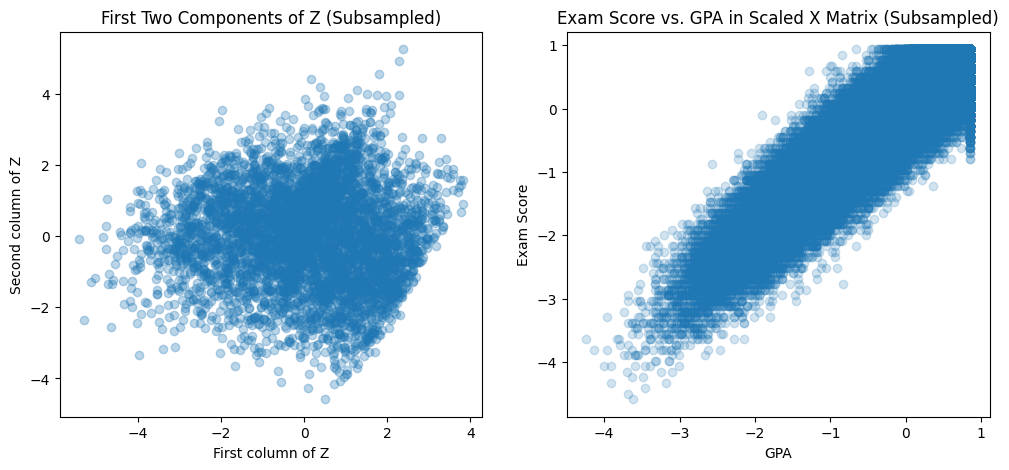

In [176]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((12, 5))

# Plot the data in the transformed space (Z)
axs[0].scatter(Z_sample[:, 0], Z_sample[:, 1], alpha = 0.3)

axs[0].set_xlabel("First column of Z")
axs[0].set_ylabel("Second column of Z")
axs[0].set_title("First Two Components of Z (Subsampled)")

# Plot two features of the original X matrix to compare
axs[1].scatter(X_scaled["previous_gpa"], X_scaled["exam_score"], alpha=0.2)
axs[1].set_xlabel("GPA")
axs[1].set_ylabel("Exam Score")
axs[1].set_title("Exam Score vs. GPA in Scaled X Matrix (Subsampled)")
plt.show()

The code below compares the correlation coefficient between the first two columns of Z, and the corr. coef. between `previous_gpa` and `exam_score` in X.

In [177]:
np.corrcoef(Z_sample[:, 0], Z_sample[:, 1])

array([[1.        , 0.00139627],
       [0.00139627, 1.        ]])

In [181]:
np.corrcoef(X_sample.loc[:, "previous_gpa"], X_sample.loc[:, "exam_score"])

array([[1.        , 0.93104399],
       [0.93104399, 1.        ]])

Discussion question: Plot the data in the first two principal components. What, if any, structure exists inherently within the data? How does this differ from plotting on two original features?